## Identification of Quora Duplicates using Embed, Encode, Attend & Predict
(based on methods described by <a href='https://explosion.ai/blog/deep-learning-formula-nlp#entailment'>Matthew Honnibal</a>)

<a id='toc'></a>
## Table of Contents
1. [Imports & Intialization](#init)
2. [Load Data (previously split into train & test)](#data_load)
3. [Embedding - GloVe](#embed)
    1. [Load pretrained GloVe model](#load_glove)
    2. [Function - Embed with GloVe](#f_glove)
    3. [Function - Embedding Layer for NN](#f_emb)
    4. [Convert train data (text to GloVe IDs)](#c_gl_train)
    5. [Convert test data (text to GloVe IDs)](#c_gl_test) 
4. [Modeling](#model)
    1. [Decomposable Attention Model](#da)
        1. [Function - Create feed-forward layer](#f_ff)
        2. [Function - Normalize attention weights](#f_norm_att)
        3. [Function - Sum a vector](#f_sum)
        4. [Function - Slice input (return one slice at a time)](#f_slice)
        5. [Function - Build decomposable attention model](#f_bld_da)
        6. [Hyperparameter optimization](#da_hyp)
            1. [Shallow optimization run](#da_hyp_run1)
            2. [Deep optimization run](#da_hyp_run2)
        7. [Train optimized model](#da_train)
        8. [Predict test data](#da_pred)
        9. [Evaluate Model](#da_eval)
    2. [Hierarchical Attention Model](#ha)
        1. [Class - Attention_Layer](#c_att_ha)
        5. [Function - Build decomposable attention model](#f_bld_ha)
        6. [Hyperparameter optimization](#ha_hyp)
            1. [Shallow optimization run](#ha_hyp_run1)
            2. [Deep optimization run](#ha_hyp_run2)
        7. [Train optimized model](#ha_train)
        8. [Predict test data](#ha_pred)
        9. [Evaluate Model](#ha_eval)

<a id='init'></a>
## Imports & Intialization
[back to table of contents](#toc)

In [3]:
import spacy
import numpy as np

import pandas as pd
import numpy as np
import pickle

import time

from keras import layers, Model, models, initializers
from keras.engine.topology import Layer
from keras import backend as K
from keras.optimizers import Adam,RMSprop, Nadam, SGD
from keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

import sys
sys.path.append('..')
from src.utils.dl_utils import init_session, data, plot_optimization_history
from src.utils.plotting import plot_roc

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform, loguniform, lognormal, normal
import gc

# change these to the appropriate data folder
f_path = '/media/siri/78C6823EC681FD1E/minio/data/'
data_folder = f_path+'dq-data/dl/'
input_folder = f_path+'dq-data/'

<a id='data_load'></a>
## Load Data (previously split into train & test)
[back to table of contents](#toc)

#### run the following cell if you have already split the data into test and train sets and saved the split data (i.e. you have already run the notebook logR_GBM.ipynb in the same location as this notebook)

In [4]:
X_train = pickle.load(open(input_folder+'X_train.p', 'rb'))
X_test = pickle.load(open(input_folder+'X_test.p', 'rb'))
y_train = pickle.load(open(input_folder+'y_train.p', 'rb'))
y_test = pickle.load(open(input_folder+'y_test.p', 'rb'))

X_train.info()

<a id='data_load'></a>
## Load Data (if previously not split into train & test)
[back to table of contents](#toc)

#### uncomment and run the following cell to load data if you have not split the data into test and train sets and saved it already (see notebook logR_GBM.ipynb in the same location as this notebook)

In [ ]:
# from sklearn.model_selection import train_test_split

# data = 'train.csv'
# filestream = input_folder+data
# dtypes = {
#     'id': 'int64',
#     'qid1': 'int64',
#     'qid2': 'int64',
#     'question1': 'object',
#     'question2': 'object',
#     'is_duplicate': 'int64'
# }
# df = pd.read_csv(
#                                      filestream,
#                                      header=0, 
#                                      usecols=dtypes.keys(), 
#                                      #names=dtypes.keys(),
#                                      skipinitialspace=True,
#                                      skip_blank_lines=True,
#                                      encoding='utf-8')
# df = df.set_index('id')
# df = df.dropna()



# X = df.drop(columns=['is_duplicate'])

# y = df['is_duplicate']
# X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.33, random_state=42)

<a id='embed'></a>
## Embedding
[back to table of contents](#toc)

<a id='load_glove'></a>
#### Load pretrained GloVe model
[back to table of contents](#toc)

In [6]:
nlp = spacy.load('en_vectors_web_lg')

<a id='f_glove'></a>
#### Function - Embed with GloVe 
[back to table of contents](#toc)

Used to convert the train and test datasets (text to IDs) based on the glove vectors. 
Accounts for OOV tokens by adding a set of OOV vectors and assigning them randomly to OOV tokens. 
This function has been taken from <a href='https://github.com/explosion/spaCy/tree/master/examples/keras_parikh_entailment'>A decomposable attention model for Natural Language Inference</a> and adapted to this problem

In [ ]:
def create_dataset(nlp, X, num_oov, max_length, norm_vectors = True):
    len_q1 = X['question1'].size
    sents = pd.concat([X['question1'], X['question2']]).values
    
    # the extra +1 is for a zero vector represting NULL for padding
    num_vectors = max(lex.rank for lex in nlp.vocab) + 2 
    
    # create random vectors for OOV tokens
    oov = np.random.normal(size=(num_oov, nlp.vocab.vectors_length))
    oov = oov / oov.sum(axis=1, keepdims=True)
    
    vectors = np.zeros((num_vectors + num_oov, nlp.vocab.vectors_length), dtype='float32')
    vectors[num_vectors:, ] = oov
    for lex in nlp.vocab:
        if lex.has_vector and lex.vector_norm > 0:
            vectors[lex.rank + 1] = lex.vector / lex.vector_norm if norm_vectors == True else lex.vector
            
    sents_as_ids = []
    for sent in sents:
        doc = nlp(sent)
        word_ids = []
        
        for i, token in enumerate(doc):
            # skip odd spaces from tokenizer
            if token.has_vector and token.vector_norm == 0:
                continue
                
            if i > max_length:
                break
                
            if token.has_vector:
                word_ids.append(token.rank + 1)
            else:
                # if we don't have a vector, pick an OOV entry
                word_ids.append(token.rank % num_oov + num_vectors) 
                
        # there must be a simpler way of generating padded arrays from lists...
        word_id_vec = np.zeros((max_length), dtype='int')
        clipped_len = min(max_length, len(word_ids))
        word_id_vec[:clipped_len] = word_ids[:clipped_len]
        sents_as_ids.append(word_id_vec)        
        
    return vectors, np.array(sents_as_ids[:len_q1]), np.array(sents_as_ids[len_q1:])

<a id='f_emb'></a>
#### Function - Embedding Layer for NN
[back to table of contents](#toc)

In [8]:
def create_embedding(vectors, max_length, projected_dim):
    return models.Sequential([
        layers.Embedding(
            vectors.shape[0],
            vectors.shape[1],
            input_length=max_length,
            weights=[vectors],
            trainable=False),
        
        layers.TimeDistributed(
            layers.Dense(projected_dim,
                         activation=None,
                         use_bias=False))
    ])

<a id='c_gl_train'></a>
#### Convert train data (text to GloVe IDs)
[back to table of contents](#toc)

In [ ]:
w2v, q1_train_w2v, q2_train_w2v = create_dataset(nlp, X_train, 100, 50, True)

pickle.dump(w2v, open(data_folder+'w2v.p', 'wb'))
pickle.dump(q1_train_w2v, open(data_folder+'q1_train_w2v.p', 'wb'))
pickle.dump(q2_train_w2v, open(data_folder+'q2_train_w2v.p', 'wb'))

<a id='c_gl_test'></a>
#### Convert test data (text to GloVe IDs)
[back to table of contents](#toc)

In [ ]:
_, q1_test_w2v, q2_test_w2v = create_dataset(nlp, X_test, 100, 50, True)


pickle.dump(q1_test_w2v, open(data_folder+'q1_test_w2v.p', 'wb'))
pickle.dump(q2_test_w2v, open(data_folder+'q2_test_w2v.p', 'wb'))

<a id='model'></a>
## Modeling
[back to table of contents](#toc)

#### load previously pickled word vectors and train and test token IDs

In [ ]:
w2v = pickle.load(open(data_folder+'w2v.p', 'rb'))
q1_train_w2v = pickle.load(open(data_folder+'q1_train_w2v.p', 'rb'))
q2_train_w2v = pickle.load(open(data_folder+'q2_train_w2v.p', 'rb'))
q1_test_w2v = pickle.load(open(data_folder+'q1_test_w2v.p', 'rb'))
q2_test_w2v = pickle.load(open(data_folder+'q2_test_w2v.p', 'rb'))

<a id='da'></a>
### Decomposable Attention Model
(based on Example 1. <a href='https://explosion.ai/blog/deep-learning-formula-nlp'>A Decomposable Attention Model for Natural Language Inference</a>)

[back to table of contents](#toc)

<a id='f_ff'></a>
#### Function - Create feed-forward layer
[back to table of contents](#toc)

In [35]:
def create_feedforward(num_units, dropout_rate, activation='relu'):
    return models.Sequential([
        layers.Dense(num_units, activation=activation, use_bias=True),
        layers.Dropout(dropout_rate),
        layers.Dense(num_units, activation=activation, use_bias=True),
        layers.Dropout(dropout_rate)
    ])

<a id='f_norm_att'></a>
#### Function - Normalize attention weights
(as described in 3.1 of <a href='https://arxiv.org/pdf/1606.01933v1.pdf'>Parikh et al.</a>)

[back to table of contents](#toc)

In [10]:
def normalizer(axis):
    def _normalize(att_weights):
        exp_weights = K.exp(att_weights)
        sum_weights = K.sum(exp_weights, axis=axis, keepdims=True)
        return exp_weights/sum_weights
    return _normalize

<a id='f_sum'></a>
#### Function - Sum a vector
(as described in 3.3 of <a href='https://arxiv.org/pdf/1606.01933v1.pdf'>Parikh et al.</a>)

[back to table of contents](#toc)

In [11]:
def sum_word(x):
    return K.sum(x, axis=1)

<a id='f_slice'></a>
#### Function - Slice input (return one slice at a time)
to take single input instead of two in order to work with hyperas specs

[back to table of contents](#toc)

In [12]:
def get_input_slice(i):
    def _slice(inputs):
        slice_i = K.squeeze(K.slice(inputs, [0,i-1,0], [-1,1,-1]),1)
        return slice_i
    return _slice

<a id='f_bld_da'></a>
#### Function - Build decomposable attention model
(as described in 3.1 Attend, 3.2 Compare and 3.3 Aggregate of <a href='https://arxiv.org/pdf/1606.01933v1.pdf'>Parikh et al.</a>)

[back to table of contents](#toc)

In [13]:
def build_model(vectors, max_length, num_classes, projected_dim,  
                num_hidden=200, dropout_rate1=0.2, dropout_rate2=0.2, 
                dropout_rate3=0.2, learn_rate=0.0001, optimizer='nadam'):
    K.clear_session()
    #input1 = layers.Input(shape=(max_length,), dtype='int32', name='words1')
    #input2 = layers.Input(shape=(max_length,), dtype='int32', name='words2')
    
    # modified model to take single input instead of two in order to work with hyperas specs.
    model_input = layers.Input(shape=(2, max_length), dtype='int32')
    input1 = layers.Lambda(get_input_slice(1))(model_input)
    input2 = layers.Lambda(get_input_slice(2))(model_input)
    
    # embeddings (projected)
    embed = create_embedding(vectors, max_length, projected_dim)
    a = embed(input1)
    b = embed(input2)     
    
    # step 1: attend
    F = create_feedforward(num_hidden, dropout_rate=dropout_rate1)
    att_weights = layers.dot([F(a), F(b)], axes=-1, normalize=True)
    
    G = create_feedforward(num_hidden, dropout_rate=dropout_rate2)    
    
    norm_weights_a = layers.Lambda(normalizer(1))(att_weights)
    norm_weights_b = layers.Lambda(normalizer(2))(att_weights)
    alpha = layers.dot([norm_weights_a, a], axes=1)
    beta  = layers.dot([norm_weights_b, b], axes=1)

    # step 2: compare
    comp1 = layers.concatenate([a, beta])
    comp2 = layers.concatenate([b, alpha])
    v1 = layers.TimeDistributed(G)(comp1)
    v2 = layers.TimeDistributed(G)(comp2)

    # step 3: aggregate
    v1_sum = layers.Lambda(sum_word)(v1)
    v2_sum = layers.Lambda(sum_word)(v2)
    concat = layers.concatenate([v1_sum, v2_sum])
        
    H = create_feedforward(num_hidden, dropout_rate=dropout_rate3)
    out = H(concat)
    out = layers.Dense(num_classes, activation='sigmoid', use_bias=True)(out)
    
    model = Model(model_input, out)
    if optimizer == 'sgd':
        opt = SGD(lr=learn_rate)
    elif optimizer == 'adam':
        opt = Adam(lr=learn_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(lr=learn_rate)
    else:
        opt = Nadam(lr=learn_rate)
    
    model.compile(optimizer=opt,
    #model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

<a id='da_hyp'></a>
#### Hyperparameter optimization
[back to table of contents](#toc)

In [14]:
functions=[build_model, get_input_slice, create_embedding, create_feedforward, normalizer, sum_word]

<a id='da_hyp_run1'></a>
##### Shallow optimization run
[back to table of contents](#toc)

In [21]:
# function called by hyperas to build model for every evaluation (with different parameter combinations)
def create_model(x_train, y_train, x_test, y_test):
    K.clear_session()
    # this is needed to free up gpu memory after every evaluation
    gc.collect()
    w2v = pickle.load(open(data_folder+'w2v.p', 'rb'))
    model = build_model(vectors=w2v, max_length=50, projected_dim=200, num_classes=1, 
                        num_hidden=200, dropout_rate1={{uniform(0, 1)}}, 
                        dropout_rate2={{uniform(0, 1)}}, dropout_rate3={{uniform(0, 1)}},
                        optimizer={{choice(['sgd', 'rmsprop','nadam', 'adam'])}},
                        learn_rate={{loguniform(-6,-3)}})
    result = model.fit(x_train, y_train, batch_size= {{choice([32, 64, 128])}}, epochs=2,
      validation_split=0.2)
    validation_acc = np.amax(result.history['val_acc']) 
    print('Best validation accuracy of eval run:', validation_acc)
    print('history of eval run:', result.history)
    return {'loss': -validation_acc, 'status': STATUS_OK,
            'train_acc': np.amax(result.history['acc'])}

In [17]:
init_session()
model1_run1_trials=Trials()
# hyperas optimize
model1_run1_best = optim.minimize(model=create_model,
                          data=data,
                          algo=tpe.suggest,
                          functions=functions,
                          max_evals=50,
                          trials=model1_run1_trials,
                          notebook_name='DL_encode_attend')

>>> Imports:
#coding=utf-8

try:
    import spacy
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import pickle
except:
    pass

try:
    import spacy
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import pickle
except:
    pass

try:
    from keras import layers, Model, models, initializers
except:
    pass

try:
    from keras.engine.topology import Layer
except:
    pass

try:
    from keras import backend as K
except:
    pass

try:
    from keras.optimizers import Adam, RMSprop, Nadam, SGD
except:
    pass

try:
    from keras.wrappers.scikit_learn import KerasClassifier
except:
    pass

try:
    from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
except:
    pass

try:
    from sklearn.metrics import accuracy_score
except:
    p

Train on 216697 samples, validate on 54175 samples
Epoch 1/2
216697/216697 [==============================] - 32s 149us/step - loss: 0.6281 - acc: 0.6552 - val_loss: 0.6440 - val_acc: 0.6361
Epoch 2/2
216697/216697 [==============================] - 31s 145us/step - loss: 0.6194 - acc: 0.6573 - val_loss: 0.6194 - val_acc: 0.6377
Best validation accuracy of eval run: 0.6376742039565177
history of eval run: {'val_loss': [0.6440065463820415, 0.6194075072620341], 'val_acc': [0.6360682971916498, 0.6376742039565177], 'loss': [0.6280545650397935, 0.619427458560793], 'acc': [0.6551775059294046, 0.6573095151329961]}
Train on 216697 samples, validate on 54175 samples
Epoch 1/2
216697/216697 [==============================] - 29s 136us/step - loss: 0.6351 - acc: 0.6280 - val_loss: 0.6542 - val_acc: 0.5889
Epoch 2/2
216697/216697 [==============================] - 29s 134us/step - loss: 0.6219 - acc: 0.6381 - val_loss: 0.6497 - val_acc: 0.5857
Best validation accuracy of eval run: 0.58890632209328

Train on 216697 samples, validate on 54175 samples
Epoch 1/2
216697/216697 [==============================] - 38s 175us/step - loss: 5.9517 - acc: 0.6306 - val_loss: 5.9733 - val_acc: 0.6294
Epoch 2/2
216697/216697 [==============================] - 37s 173us/step - loss: 5.9533 - acc: 0.6306 - val_loss: 5.9733 - val_acc: 0.6294
Best validation accuracy of eval run: 0.6294047069725597
history of eval run: {'val_loss': [5.973290318646186, 5.973290318646186], 'val_acc': [0.6294047069725597, 0.6294047069725597], 'loss': [5.951668246387388, 5.953290203704385], 'acc': [0.630576334699133, 0.6306455557812637]}
Train on 216697 samples, validate on 54175 samples
Epoch 1/2
216697/216697 [==============================] - 41s 190us/step - loss: 5.9518 - acc: 0.6306 - val_loss: 5.9733 - val_acc: 0.6294
Epoch 2/2
216697/216697 [==============================] - 40s 187us/step - loss: 5.9534 - acc: 0.6306 - val_loss: 5.9733 - val_acc: 0.6294
Best validation accuracy of eval run: 0.6294047069725597
h

In [18]:
print("Best performing model hyper-parameters:")
print(model1_run1_best)

Best performing model hyper-parameters:
({'batch_size': 1, 'dropout_rate1': 0.9322247223365211, 'dropout_rate1_1': 0.05693487970104716, 'dropout_rate1_2': 0.3513601920510685, 'learn_rate': 0.0029991793113097456, 'optimizer': 3}, None)


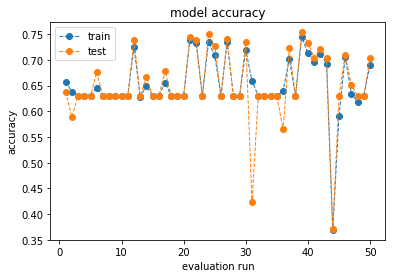

In [22]:
plot_optimization_history(model1_run1_trials)

In [ ]:
# save optimization results for later use
pickle.dump(model1_run1_best, open(data_folder+'model1_run1_best.p', 'wb'))
pickle.dump(model1_run1_trials, open(data_folder+'model1_run1_trials.p', 'wb'))

<a id='da_hyp_run2'></a>
##### Deep optimization run
[back to table of contents](#toc)

In [15]:
# function called by hyperas to build model for every evaluation (with different parameter combinations)
# need a different definition from the shallow run, as the variable parameters are different
def create_model(x_train, y_train, x_test, y_test):
    K.clear_session()
    # this is needed to free up gpu memory after every evaluation
    gc.collect()
    w2v = pickle.load(open(data_folder+'w2v.p', 'rb'))
    model = build_model(vectors=w2v, max_length=50, projected_dim=200, num_classes=1, 
                        num_hidden=200, dropout_rate1={{uniform(0, 1)}}, 
                        dropout_rate2={{uniform(0, 1)}}, dropout_rate3={{uniform(0, 1)}},
                        optimizer={{choice(['sgd', 'rmsprop','nadam', 'adam'])}},
                        learn_rate={{loguniform(-6,-3)}})
    early_stopping = EarlyStopping(monitor='val_loss', patience=3)
    result = model.fit(x_train, y_train, batch_size= 64, epochs=20,
      validation_split=0.2, callbacks=[early_stopping])
    validation_acc = np.amax(result.history['val_acc']) 
    print('Best validation accuracy of eval run:', validation_acc)
    print('history of eval run:', result.history)
    return {'loss': -validation_acc, 'status': STATUS_OK,
            'train_acc': np.amax(result.history['acc'])}

In [16]:
init_session()
model1_run2_trials=Trials()

t0 = time.time()
# hyperas optimizer
model1_run2_best = optim.minimize(model=create_model,
                          data=data,
                          algo=tpe.suggest,
                          functions=functions,
                          max_evals=50,
                          trials=model1_run2_trials,
                          notebook_name='DL_encode_attend')
t1 = time.time() - t0
print(t1)

>>> Imports:
#coding=utf-8

try:
    import spacy
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import pickle
except:
    pass

try:
    import spacy
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import pickle
except:
    pass

try:
    import time
except:
    pass

try:
    from keras import layers, Model, models, initializers
except:
    pass

try:
    from keras.engine.topology import Layer
except:
    pass

try:
    from keras import backend as K
except:
    pass

try:
    from keras.optimizers import Adam, RMSprop, Nadam, SGD
except:
    pass

try:
    from keras.callbacks import EarlyStopping
except:
    pass

try:
    from sklearn.metrics import accuracy_score
except:
    pass

try:
    from sklearn.metrics import precision_score
except:
    p

Train on 216697 samples, validate on 54175 samples
Epoch 1/20
216697/216697 [==============================] - 40s 186us/step - loss: 0.6618 - acc: 0.6278 - val_loss: 0.6599 - val_acc: 0.6294
Epoch 2/20
216697/216697 [==============================] - 40s 184us/step - loss: 0.8999 - acc: 0.6271 - val_loss: 0.6593 - val_acc: 0.6294
Epoch 3/20
216697/216697 [==============================] - 40s 184us/step - loss: 0.9116 - acc: 0.6274 - val_loss: 0.6593 - val_acc: 0.6294
Epoch 4/20
216697/216697 [==============================] - 40s 184us/step - loss: 1.6592 - acc: 0.6216 - val_loss: 0.6595 - val_acc: 0.6294
Epoch 5/20
216697/216697 [==============================] - 40s 184us/step - loss: 1.9243 - acc: 0.6178 - val_loss: 5.9733 - val_acc: 0.6294
Epoch 6/20
216697/216697 [==============================] - 40s 184us/step - loss: 2.4517 - acc: 0.6174 - val_loss: 5.9733 - val_acc: 0.6294
Best validation accuracy of eval run: 0.6294047069725597
history of eval run: {'val_loss': [0.659918749

Epoch 6/20
216697/216697 [==============================] - 40s 184us/step - loss: 0.5986 - acc: 0.6856 - val_loss: 0.5875 - val_acc: 0.7099
Epoch 7/20
216697/216697 [==============================] - 40s 184us/step - loss: 0.5969 - acc: 0.6859 - val_loss: 0.5871 - val_acc: 0.7083
Best validation accuracy of eval run: 0.7098661744369028
history of eval run: {'val_loss': [0.6206647954407407, 0.5962569428084356, 0.593220702148441, 0.5864934797516934, 0.5895440172753028, 0.5874503746487107, 0.5870923181981825], 'val_acc': [0.676437471161584, 0.6932533456237293, 0.7028703276441017, 0.7002307337343721, 0.6958006460401502, 0.7098661744369028, 0.708334102447978], 'loss': [0.6251815385578453, 0.6188609357335071, 0.6055439459534181, 0.6006818375858695, 0.5997512063970223, 0.5986427138521893, 0.596936946668402], 'acc': [0.6623257359365308, 0.6674111778188955, 0.6754315934283007, 0.6801247825238443, 0.6840242366063249, 0.6855840182330458, 0.6858978204543059]}
Train on 216697 samples, validate on 

216697/216697 [==============================] - 37s 172us/step - loss: 0.5458 - acc: 0.7286 - val_loss: 0.5763 - val_acc: 0.6617
Epoch 3/20
216697/216697 [==============================] - 37s 171us/step - loss: 0.5748 - acc: 0.7160 - val_loss: 0.5795 - val_acc: 0.7025
Epoch 4/20
216697/216697 [==============================] - 37s 171us/step - loss: 0.6324 - acc: 0.6956 - val_loss: 0.6670 - val_acc: 0.6940
Best validation accuracy of eval run: 0.7431472081075245
history of eval run: {'val_loss': [0.5245814619594639, 0.5763193200984527, 0.5794990224864662, 0.6669995107087442], 'val_acc': [0.7431472081075245, 0.6617443470103321, 0.7025196123695285, 0.6939547761750761], 'loss': [1.6785099566407236, 0.5458267374215604, 0.5748261560734838, 0.632389973839517], 'acc': [0.6973885194490294, 0.7285795373199864, 0.7160274484723338, 0.695551853517166]}
Train on 216697 samples, validate on 54175 samples
Epoch 1/20
216697/216697 [==============================] - 39s 181us/step - loss: 1.1570 - ac

Train on 216697 samples, validate on 54175 samples
Epoch 1/20
216697/216697 [==============================] - 38s 174us/step - loss: 0.6373 - acc: 0.6710 - val_loss: 0.6204 - val_acc: 0.6773
Epoch 2/20
216697/216697 [==============================] - 37s 171us/step - loss: 0.6326 - acc: 0.6718 - val_loss: 0.6388 - val_acc: 0.6665
Epoch 3/20
216697/216697 [==============================] - 37s 171us/step - loss: 0.6595 - acc: 0.6669 - val_loss: 0.6498 - val_acc: 0.6412
Epoch 4/20
216697/216697 [==============================] - 37s 171us/step - loss: 0.6806 - acc: 0.6602 - val_loss: 0.6657 - val_acc: 0.6059
Best validation accuracy of eval run: 0.6773419473960095
history of eval run: {'val_loss': [0.6203924334214258, 0.6387779773167327, 0.6498382136774438, 0.6656631425409533], 'val_acc': [0.6773419473960095, 0.6665251499637239, 0.6411998154009109, 0.6059067835585555], 'loss': [0.6373273823655333, 0.6326186909638388, 0.6595233294974476, 0.6805584581812463], 'acc': [0.6710106738855948, 0

Train on 216697 samples, validate on 54175 samples
Epoch 1/20
216697/216697 [==============================] - 36s 166us/step - loss: 0.6281 - acc: 0.6372 - val_loss: 0.6063 - val_acc: 0.6540
Epoch 2/20
216697/216697 [==============================] - 35s 163us/step - loss: 0.6101 - acc: 0.6558 - val_loss: 0.5931 - val_acc: 0.6799
Epoch 3/20
216697/216697 [==============================] - 35s 163us/step - loss: 0.5979 - acc: 0.6702 - val_loss: 0.5822 - val_acc: 0.6886
Epoch 4/20
216697/216697 [==============================] - 35s 163us/step - loss: 0.5892 - acc: 0.6805 - val_loss: 0.5799 - val_acc: 0.6896
Epoch 5/20
216697/216697 [==============================] - 35s 163us/step - loss: 0.5811 - acc: 0.6879 - val_loss: 0.5694 - val_acc: 0.6986
Epoch 6/20
216697/216697 [==============================] - 35s 163us/step - loss: 0.5753 - acc: 0.6938 - val_loss: 0.5792 - val_acc: 0.6813
Epoch 7/20
216697/216697 [==============================] - 35s 163us/step - loss: 0.5702 - acc: 0.6984

Train on 216697 samples, validate on 54175 samples
Epoch 1/20
216697/216697 [==============================] - 36s 166us/step - loss: 0.6084 - acc: 0.6579 - val_loss: 0.5744 - val_acc: 0.6971
Epoch 2/20
216697/216697 [==============================] - 35s 164us/step - loss: 0.5689 - acc: 0.6995 - val_loss: 0.5508 - val_acc: 0.7152
Epoch 3/20
216697/216697 [==============================] - 35s 164us/step - loss: 0.5471 - acc: 0.7159 - val_loss: 0.5541 - val_acc: 0.7074
Epoch 4/20
216697/216697 [==============================] - 36s 164us/step - loss: 0.5334 - acc: 0.7268 - val_loss: 0.5204 - val_acc: 0.7357
Epoch 5/20
216697/216697 [==============================] - 35s 163us/step - loss: 0.5197 - acc: 0.7361 - val_loss: 0.5099 - val_acc: 0.7376
Epoch 6/20
216697/216697 [==============================] - 35s 163us/step - loss: 0.5073 - acc: 0.7444 - val_loss: 0.5116 - val_acc: 0.7428
Epoch 7/20
216697/216697 [==============================] - 35s 163us/step - loss: 0.4979 - acc: 0.7491

Train on 216697 samples, validate on 54175 samples
Epoch 1/20
216697/216697 [==============================] - 36s 165us/step - loss: 3.2537 - acc: 0.6029 - val_loss: 5.9733 - val_acc: 0.6294
Epoch 2/20
216697/216697 [==============================] - 35s 163us/step - loss: 2.4023 - acc: 0.6153 - val_loss: 5.9733 - val_acc: 0.6294
Epoch 3/20
216697/216697 [==============================] - 35s 163us/step - loss: 2.3859 - acc: 0.6157 - val_loss: 5.9733 - val_acc: 0.6294
Epoch 4/20
216697/216697 [==============================] - 35s 163us/step - loss: 2.2586 - acc: 0.6161 - val_loss: 5.9733 - val_acc: 0.6294
Best validation accuracy of eval run: 0.6294047069725597
history of eval run: {'val_loss': [5.973290318646186, 5.973290318646186, 5.973290318646186, 5.973290318646186], 'val_acc': [0.6294047069725597, 0.6294047069725597, 0.6294047069725597, 0.6294047069725597], 'loss': [3.2537463630644767, 2.402344305951523, 2.385902643495299, 2.2586364111805732], 'acc': [0.6028832886505824, 0.61528

Train on 216697 samples, validate on 54175 samples
Epoch 1/20
216697/216697 [==============================] - 36s 166us/step - loss: 0.6474 - acc: 0.6280 - val_loss: 0.6679 - val_acc: 0.6294
Epoch 2/20
216697/216697 [==============================] - 35s 163us/step - loss: 0.6270 - acc: 0.6306 - val_loss: 0.6731 - val_acc: 0.6294
Epoch 3/20
216697/216697 [==============================] - 35s 163us/step - loss: 0.6163 - acc: 0.6391 - val_loss: 0.6657 - val_acc: 0.6822
Epoch 4/20
216697/216697 [==============================] - 35s 163us/step - loss: 0.6089 - acc: 0.6706 - val_loss: 0.6819 - val_acc: 0.5213
Epoch 5/20
216697/216697 [==============================] - 35s 163us/step - loss: 0.6042 - acc: 0.6801 - val_loss: 0.6808 - val_acc: 0.5416
Epoch 6/20
216697/216697 [==============================] - 35s 163us/step - loss: 0.6013 - acc: 0.6851 - val_loss: 0.6591 - val_acc: 0.6231
Epoch 7/20
216697/216697 [==============================] - 35s 163us/step - loss: 0.5985 - acc: 0.6889

Train on 216697 samples, validate on 54175 samples
Epoch 1/20
216697/216697 [==============================] - 36s 166us/step - loss: 0.6186 - acc: 0.6453 - val_loss: 0.6005 - val_acc: 0.6510
Epoch 2/20
216697/216697 [==============================] - 35s 164us/step - loss: 0.5973 - acc: 0.6681 - val_loss: 0.5803 - val_acc: 0.6915
Epoch 3/20
216697/216697 [==============================] - 35s 163us/step - loss: 0.5837 - acc: 0.6831 - val_loss: 0.5768 - val_acc: 0.6904
Epoch 4/20
216697/216697 [==============================] - 35s 164us/step - loss: 0.5742 - acc: 0.6925 - val_loss: 0.5621 - val_acc: 0.7041
Epoch 5/20
216697/216697 [==============================] - 35s 163us/step - loss: 0.5662 - acc: 0.7005 - val_loss: 0.5556 - val_acc: 0.7104
Epoch 6/20
216697/216697 [==============================] - 35s 163us/step - loss: 0.5594 - acc: 0.7060 - val_loss: 0.5505 - val_acc: 0.7147
Epoch 7/20
216697/216697 [==============================] - 35s 163us/step - loss: 0.5536 - acc: 0.7113

216697/216697 [==============================] - 35s 163us/step - loss: 0.4798 - acc: 0.7623 - val_loss: 0.4713 - val_acc: 0.7664
Epoch 18/20
216697/216697 [==============================] - 35s 163us/step - loss: 0.4765 - acc: 0.7647 - val_loss: 0.4732 - val_acc: 0.7670
Epoch 19/20
216697/216697 [==============================] - 35s 163us/step - loss: 0.4743 - acc: 0.7651 - val_loss: 0.4727 - val_acc: 0.7665
Epoch 20/20
216697/216697 [==============================] - 35s 163us/step - loss: 0.4714 - acc: 0.7661 - val_loss: 0.4660 - val_acc: 0.7695
Best validation accuracy of eval run: 0.7694877710967335
history of eval run: {'val_loss': [0.5890393931963612, 0.5661057594287874, 0.5663924388848091, 0.538352215875939, 0.5453842699307696, 0.5255695415577363, 0.5162736706487253, 0.5091142037286701, 0.508141275858846, 0.5467249676924891, 0.49200886703714775, 0.49195447174260626, 0.4845893919935521, 0.48255596352547725, 0.47652018538256313, 0.4752698709764511, 0.47131684743098307, 0.4731982

In [17]:
print("Best performing model hyper-parameters:")
print(model1_run2_best)

Best performing model hyper-parameters:
({'dropout_rate1': 0.6429988031383259, 'dropout_rate1_1': 0.04755846424484607, 'dropout_rate1_2': 0.5947232870685206, 'learn_rate': 0.022122461782015913, 'optimizer': 0}, None)


In [20]:
# save optimization results for later use
pickle.dump(model1_run2_best, open(data_folder+'model1_run2_best.p', 'wb'))
pickle.dump(model1_run2_trials, open(data_folder+'model1_run2_trials.p', 'wb'))

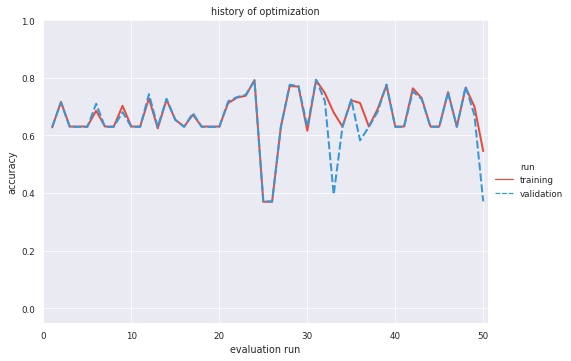

In [21]:
plot_optimization_history(model1_run2_trials)

<a id='da_train'></a>
#### Train optimized model
[back to table of contents](#toc)

In [36]:
from keras.callbacks import LearningRateScheduler
# function for exponential decay (used for learning rate decay)
def exp_decay(epoch):
    init_lr = 0.0221
    k = 0.1
    lrate = init_lr * np.exp(-k*epoch)
    return lrate

In [23]:
t0 = time.time()
init_session()
K.clear_session()
# this is needed to free up gpu memory after every evaluation
gc.collect()
# load word vectors (if already not loaded)
w2v = pickle.load(open(data_folder+'w2v.p', 'rb'))
x_train, y_train, x_test, y_test = data()

# set parameters to the values returned by the deep optimization run
dropout_rate1 = 0.643
dropout_rate2 = 0.0475
dropout_rate3 = 0.595
optimizer = 'sgd'
#learn_rate = 0.0221
learn_rate = LearningRateScheduler(exp_decay)
m1 = build_model(vectors=w2v, max_length=50, projected_dim=300, num_classes=1, 
                        num_hidden=200, dropout_rate1=dropout_rate1, 
                        dropout_rate2=dropout_rate2, dropout_rate3=dropout_rate3,
                        optimizer=optimizer,
                        learn_rate=0.0)
#early_stopping = EarlyStopping(monitor='val_loss', patience=4)
result_1 = m1.fit(x_train, y_train, batch_size= 64, epochs=50,
      validation_split=0.1, callbacks=[learn_rate])
t1 = time.time() - t0
print(t1)

Train on 243784 samples, validate on 27088 samples
Epoch 1/50
243784/243784 [==============================] - 43s 175us/step - loss: 0.6161 - acc: 0.6516 - val_loss: 0.5812 - val_acc: 0.6971
Epoch 2/50
243784/243784 [==============================] - 42s 173us/step - loss: 0.5761 - acc: 0.7001 - val_loss: 0.5584 - val_acc: 0.7115
Epoch 3/50
243784/243784 [==============================] - 42s 173us/step - loss: 0.5524 - acc: 0.7192 - val_loss: 0.5740 - val_acc: 0.6941
Epoch 4/50
243784/243784 [==============================] - 42s 173us/step - loss: 0.5367 - acc: 0.7306 - val_loss: 0.5325 - val_acc: 0.7277
Epoch 5/50
243784/243784 [==============================] - 42s 173us/step - loss: 0.5231 - acc: 0.7393 - val_loss: 0.5148 - val_acc: 0.7415
Epoch 6/50
243784/243784 [==============================] - 42s 173us/step - loss: 0.5129 - acc: 0.7455 - val_loss: 0.5142 - val_acc: 0.7410
Epoch 7/50
243784/243784 [==============================] - 42s 174us/step - loss: 0.5039 - acc: 0.7510

<a id='da_pred'></a>
#### Predict test data
[back to table of contents](#toc)

In [24]:
target_names = ['not duplicate', 'duplicate']

convert_binary = lambda x: 1 if x[0] >= .5 else 0

#m.evaluate(test_sents,y_test)

y_pred_dl1 = m1.predict(x_test, batch_size=64)

y_pred_dl1_classes = np.array([convert_binary(y) for y in y_pred_dl1])

<a id='da_eval'></a>
#### Evaluate Model
[back to table of contents](#toc)

In [29]:
score_dl1 = accuracy_score(y_test.values, y_pred_dl1_classes)
rscore_dl1 = recall_score(y_test.values, y_pred_dl1_classes)
pscore_dl1 = precision_score(y_test.values, y_pred_dl1_classes)
print('Accuracy score for DL method 1 ', score_dl1)
print('Recall score for DL method 1  ', rscore_dl1)
print('Precision score for DL method 1  ', pscore_dl1)

Accuracy score for DL method 1  0.7860435483266499
Recall score for DL method 1   0.7300805729632945
Precision score for DL method 1   0.7013545474091594


In [30]:
print(classification_report(y_test.values, y_pred_dl1_classes, target_names=target_names))

               precision    recall  f1-score   support

not duplicate       0.84      0.82      0.83     84267
    duplicate       0.70      0.73      0.72     49148

    micro avg       0.79      0.79      0.79    133415
    macro avg       0.77      0.77      0.77    133415
 weighted avg       0.79      0.79      0.79    133415



In [33]:
m1_fpr, m1_tpr, _ = roc_curve(y_test.values, y_pred_dl1_classes)
m1_roc_auc = auc(m1_fpr, m1_tpr)

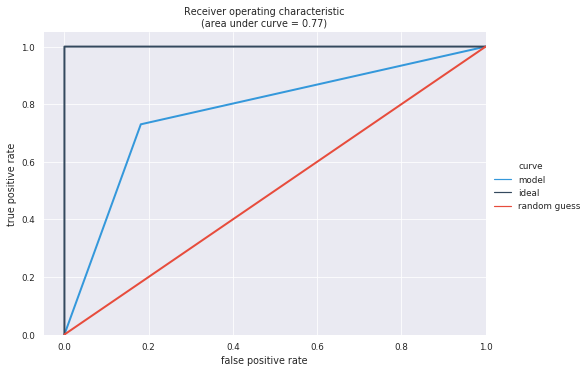

In [34]:
plot_roc(m1_fpr, m1_tpr, m1_roc_auc)

<a id='ha'></a>
### Hierarchical Attention Model
(Code implemented based on algorithm described at Example 2: <a href='https://explosion.ai/blog/deep-learning-formula-nlp'>Hierarchical Attention Networks for Document Classification</a>). 

[back to table of contents](#toc)

<a id='c_att_ha'></a>
#### Class - Attention_Layer
(custom keras layer to implement the attention mechanism (with trainable weights) for the NN. Implementation based on word and sentence attention layers described in <a href='https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf'>Yang et al.</a> and <a href='https://keras.io/layers/writing-your-own-keras-layers/'>keras custom layer example</a>)

[back to table of contents](#toc)

In [14]:
from keras.layers import Layer, RNN

class Attention_Layer(Layer):

    def __init__(self, output_dim):
        self.output_dim = output_dim
        super(Attention_Layer, self).__init__()

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.W = self.add_weight(name='W', 
                                      shape=(input_shape[-1], self.output_dim),
                                      initializer='uniform',
                                      trainable=True)
        self.b = self.add_weight(name='b', 
                                      shape=(self.output_dim,),
                                      initializer='uniform',
                                      trainable=True)
        self.u = self.add_weight(name='u', 
                                      shape=(self.output_dim,1),
                                      initializer='uniform',
                                      trainable=True)
        super(Attention_Layer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, h_it):        
        u_it = K.tanh(K.bias_add(K.dot(h_it, self.W), self.b))
        att_weights = K.dot(u_it, self.u)
        exp_weights = K.exp(att_weights)
        sum_weights = K.sum(exp_weights, axis=1, keepdims=True)
        alpha_it = exp_weights/sum_weights
        return K.sum(h_it*alpha_it, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

<a id='f_bld_ha'></a>
#### Function - Build hierarchical attention model
(implementation based on GRU-based word and sentence encoders and word and sentence attention layers described at <a href='https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf'>Yang et al.</a>)

[back to table of contents](#toc)

In [15]:
def build_hier_model(vectors, optimizer, learn_rate, dropout_rate1, dropout_rate2, max_length=50, num_hidden=200, num_classes=1, 
                projected_dim=200):
    #optimizer=params['optimizer']
    #learn_rate=params['learn_rate']
    #dropout_rate1=params['dropout_rate1']
    #dropout_rate2=params['dropout_rate1']
    #K.clear_session()
    # input    
    model_input = layers.Input(shape=(2, max_length), dtype='int32')
    
    # embeddings (projected)
    embed = create_embedding(vectors, max_length, projected_dim)
    
    # step 1: word encoder
    word_sequence_input = layers.Input(shape=(max_length,), dtype='int32')
    h_w = layers.Bidirectional(layers.GRU(num_hidden, dropout=dropout_rate1, return_sequences=True))(embed(word_sequence_input))
    
    # step 2: word attention
    s_w = Attention_Layer(num_hidden)(h_w)
    word_encode_attend = Model(word_sequence_input, s_w)
    
    # step 3: sentence encoder
    sent_encode_attend = layers.TimeDistributed(word_encode_attend)(model_input)
    h = layers.Bidirectional(layers.GRU(num_hidden, dropout=dropout_rate2, return_sequences=True))(sent_encode_attend)
    
    # step 4: sentence attention
    v = Attention_Layer(num_hidden)(h)
    
    # step 5: final classification
    out = layers.Dense(num_classes, activation='sigmoid', use_bias=True)(v)
    
    model = Model(model_input, out)
    
    if optimizer == 'sgd':
        opt = SGD(lr=learn_rate)
    elif optimizer == 'adam':
        opt = Adam(lr=learn_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(lr=learn_rate)
    else:
        opt = Nadam(lr=learn_rate)
    
    model.compile(optimizer=opt,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

<a id='ha_hyp'></a>
#### Hyperparameter optimization - Hyperopt
[back to table of contents](#toc)

<a id='ha_hyp_run1'></a>
##### Shallow optimization run
[back to table of contents](#toc)

In [17]:
from hyperopt import fmin, tpe, hp, Trials
from hyperopt import STATUS_OK

x_train, y_train, x_test, y_test = data()
w2v = pickle.load(open(data_folder+'w2v.p', 'rb'))

In [37]:
# optimization function which will be called by hyperopt with the different parameter combinations
def opt_fn(params):
    K.clear_session()
    # this is needed to free up gpu memory after every evaluation
    gc.collect()
    model = build_hier_model(vectors=w2v, params=params, max_length=50, projected_dim=200, num_classes=1, 
                        num_hidden=200)
    result = model.fit(x_train, y_train, batch_size= params['batch_size'], epochs=2,
      validation_split=0.2)
    validation_acc = np.amax(result.history['val_acc']) 
    print('Best validation accuracy of eval run:', validation_acc)
    #print('history of eval run:', result.history)
    return {'loss': -validation_acc, 'status': STATUS_OK,
            'train_acc': np.amax(result.history['acc'])}

In [39]:
# search space for all variable hyperparameters
search_space = {
                'optimizer':hp.choice('optimizer',['sgd', 'rmsprop','nadam', 'adam']),
                'learn_rate':hp.loguniform('learn_rate',-6,-3),
                'dropout_rate1':hp.uniform('dropout_rate1',0, 1),
                'dropout_rate2':hp.uniform('dropout_rate2',0, 1),
                'batch_size':hp.choice('batch_size',[32, 64, 128])
                }

In [21]:
init_session()
model2_run1_trials=Trials()

# hyperopt optimization
model2_run1_best = fmin(opt_fn,
                        search_space,
                          algo=tpe.suggest,
                          max_evals=50,
                           trials=model2_run1_trials)

Train on 216697 samples, validate on 54175 samples
Epoch 1/2
216697/216697 [==============================] - 277s 1ms/step - loss: 0.6385 - acc: 0.6466 - val_loss: 0.5898 - val_acc: 0.6887
Epoch 2/2
216697/216697 [==============================] - 275s 1ms/step - loss: 0.6118 - acc: 0.6699 - val_loss: 0.6190 - val_acc: 0.6958
Best validation accuracy of eval run: 0.6958191047399123
Train on 216697 samples, validate on 54175 samples
Epoch 1/2
216697/216697 [==============================] - 539s 2ms/step - loss: 0.5782 - acc: 0.6941 - val_loss: 0.5558 - val_acc: 0.7083
Epoch 2/2
216697/216697 [==============================] - 537s 2ms/step - loss: 0.5634 - acc: 0.7064 - val_loss: 0.5683 - val_acc: 0.7007
Best validation accuracy of eval run: 0.7083341024501785
Train on 216697 samples, validate on 54175 samples
Epoch 1/2
216697/216697 [==============================] - 151s 699us/step - loss: 0.5657 - acc: 0.7026 - val_loss: 0.5545 - val_acc: 0.7084
Epoch 2/2
216697/216697 [===========

216697/216697 [==============================] - 539s 2ms/step - loss: 0.6151 - acc: 0.6673 - val_loss: 0.6230 - val_acc: 0.6826
Epoch 2/2
216697/216697 [==============================] - 537s 2ms/step - loss: 0.5978 - acc: 0.6861 - val_loss: 0.5793 - val_acc: 0.6895
Best validation accuracy of eval run: 0.6894508537016104
Train on 216697 samples, validate on 54175 samples
Epoch 1/2
216697/216697 [==============================] - 539s 2ms/step - loss: 0.5608 - acc: 0.7073 - val_loss: 0.5512 - val_acc: 0.7143
Epoch 2/2
216697/216697 [==============================] - 539s 2ms/step - loss: 0.5349 - acc: 0.7293 - val_loss: 0.5788 - val_acc: 0.6885
Best validation accuracy of eval run: 0.7142593447029948
Train on 216697 samples, validate on 54175 samples
Epoch 1/2
216697/216697 [==============================] - 150s 692us/step - loss: 0.5724 - acc: 0.6978 - val_loss: 0.5295 - val_acc: 0.7265
Epoch 2/2
216697/216697 [==============================] - 149s 686us/step - loss: 0.5260 - acc: 

In [22]:
print("Best performing model hyper-parameters:")
print(model2_run1_best)

Best performing model hyper-parameters:
{'batch_size': 2, 'dropout_rate1': 0.3017008313578352, 'dropout_rate2': 0.8239975787678413, 'learn_rate': 0.0032509902881898665, 'optimizer': 1}


In [23]:
# save optimization results for later use
pickle.dump(model2_run1_best, open(data_folder+'model2_run1_best.p', 'wb'))
pickle.dump(model2_run1_trials, open(data_folder+'model2_run1_trials.p', 'wb'))

In [106]:
# load previously saved optimization results saved earlier
model2_run1_trials = pickle.load(open(data_folder+'model2_run1_trials.p', 'rb'))

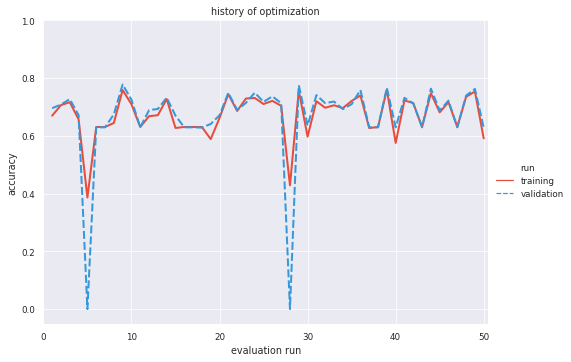

In [145]:
plot_optimization_history(model2_run1_trials)

<a id='ha_hyp_run2'></a>
##### Deep optimization run
[back to table of contents](#toc)

In [19]:
from keras.callbacks import LearningRateScheduler
# function for exponential decay (used for laerning rate)
def model2_exp_decay(init_lr, k):
    def _exp_decay(epoch):
        lrate = init_lr * np.exp(-k*epoch)
        return lrate
    return _exp_decay

In [20]:
# optimization function which will be called by hyperopt for each combination of variable parameters
def opt_deep_fn(params):
    K.clear_session()
    # this is needed to free up gpu memory after every evaluation
    gc.collect()
    model = build_hier_model(vectors=w2v, optimizer='rmsprop', 
                             learn_rate=0.0, dropout_rate1=params['dropout_rate1'], 
                             dropout_rate2=params['dropout_rate2'], max_length=50, projected_dim=200, 
                             num_classes=1, num_hidden=200)
    early_stopping = EarlyStopping(monitor='val_loss', patience=3)
    learn_rate = LearningRateScheduler(model2_exp_decay(params['learn_rate'], params['decay']))
    result = model.fit(x_train, y_train, batch_size= 128, epochs=20,
      validation_split=0.2, callbacks=[early_stopping, learn_rate])
    validation_acc = np.amax(result.history['val_acc']) 
    print('Best validation accuracy of eval run:', validation_acc)
    #print('history of eval run:', result.history)
    return {'loss': -validation_acc, 'status': STATUS_OK,
            'train_acc': np.amax(result.history['acc'])}

In [21]:
# search space for all variable hyperparameters
search_deep_space = {
                'learn_rate':hp.loguniform('learn_rate',-6,-3),
                'dropout_rate1':hp.uniform('dropout_rate1',0, 1),
                'dropout_rate2':hp.uniform('dropout_rate2',0, 1),
                'decay':hp.uniform('decay',0, 1)
                }

In [22]:
init_session()
model2_run2_trials=Trials()

# hyperopt optimization
model2_run2_best = fmin(opt_deep_fn,
                        search_deep_space,
                          algo=tpe.suggest,
                          max_evals=50,
                           trials=model2_run2_trials)

Train on 216697 samples, validate on 54175 samples
Epoch 1/20
216697/216697 [==============================] - 150s 690us/step - loss: 0.7015 - acc: 0.5931 - val_loss: 0.6658 - val_acc: 0.6294
Epoch 2/20
216697/216697 [==============================] - 148s 681us/step - loss: 6.9155 - acc: 0.2025 - val_loss: 10.0342 - val_acc: 0.0000e+00
Epoch 3/20
216697/216697 [==============================] - 148s 683us/step - loss: 10.0540 - acc: 0.0000e+00 - val_loss: 10.0342 - val_acc: 0.0000e+00
Epoch 4/20
216697/216697 [==============================] - 148s 682us/step - loss: 10.0540 - acc: 0.0000e+00 - val_loss: 10.0342 - val_acc: 0.0000e+00
Best validation accuracy of eval run: 0.6294416243698832
Train on 216697 samples, validate on 54175 samples
Epoch 1/20
216697/216697 [==============================] - 151s 695us/step - loss: 0.6409 - acc: 0.6412 - val_loss: 0.6430 - val_acc: 0.6844
Epoch 2/20
216697/216697 [==============================] - 149s 686us/step - loss: 0.6052 - acc: 0.6719 -

Epoch 6/20
216697/216697 [==============================] - 149s 688us/step - loss: 0.4742 - acc: 0.7688 - val_loss: 0.4835 - val_acc: 0.7609
Epoch 7/20
216697/216697 [==============================] - 149s 688us/step - loss: 0.4668 - acc: 0.7731 - val_loss: 0.4630 - val_acc: 0.7745
Epoch 8/20
216697/216697 [==============================] - 149s 687us/step - loss: 0.4621 - acc: 0.7768 - val_loss: 0.4657 - val_acc: 0.7726
Epoch 9/20
216697/216697 [==============================] - 149s 687us/step - loss: 0.4574 - acc: 0.7799 - val_loss: 0.4592 - val_acc: 0.7774
Epoch 10/20
216697/216697 [==============================] - 149s 688us/step - loss: 0.4554 - acc: 0.7805 - val_loss: 0.4597 - val_acc: 0.7770
Epoch 11/20
216697/216697 [==============================] - 149s 688us/step - loss: 0.4536 - acc: 0.7813 - val_loss: 0.4588 - val_acc: 0.7778
Epoch 12/20
216697/216697 [==============================] - 149s 688us/step - loss: 0.4515 - acc: 0.7832 - val_loss: 0.4611 - val_acc: 0.7757
Epo

Epoch 3/20
216697/216697 [==============================] - 149s 688us/step - loss: 0.5483 - acc: 0.7177 - val_loss: 0.5301 - val_acc: 0.7295
Epoch 4/20
216697/216697 [==============================] - 149s 687us/step - loss: 0.5312 - acc: 0.7290 - val_loss: 0.5266 - val_acc: 0.7326
Epoch 5/20
216697/216697 [==============================] - 149s 689us/step - loss: 0.5222 - acc: 0.7355 - val_loss: 0.5159 - val_acc: 0.7388
Epoch 6/20
216697/216697 [==============================] - 149s 688us/step - loss: 0.5166 - acc: 0.7393 - val_loss: 0.5118 - val_acc: 0.7425
Epoch 7/20
216697/216697 [==============================] - 149s 688us/step - loss: 0.5142 - acc: 0.7398 - val_loss: 0.5091 - val_acc: 0.7437
Epoch 8/20
216697/216697 [==============================] - 149s 687us/step - loss: 0.5127 - acc: 0.7408 - val_loss: 0.5079 - val_acc: 0.7458
Epoch 9/20
216697/216697 [==============================] - 149s 687us/step - loss: 0.5121 - acc: 0.7415 - val_loss: 0.5081 - val_acc: 0.7460
Epoch 

Epoch 6/20
216697/216697 [==============================] - 149s 687us/step - loss: 0.4296 - acc: 0.7939 - val_loss: 0.4402 - val_acc: 0.7881
Epoch 7/20
216697/216697 [==============================] - 149s 688us/step - loss: 0.4195 - acc: 0.8005 - val_loss: 0.4420 - val_acc: 0.7862
Epoch 8/20
216697/216697 [==============================] - 149s 687us/step - loss: 0.4098 - acc: 0.8069 - val_loss: 0.4295 - val_acc: 0.7945
Epoch 9/20
216697/216697 [==============================] - 149s 687us/step - loss: 0.4010 - acc: 0.8119 - val_loss: 0.4268 - val_acc: 0.7988
Epoch 10/20
216697/216697 [==============================] - 149s 687us/step - loss: 0.3948 - acc: 0.8154 - val_loss: 0.4225 - val_acc: 0.8001
Epoch 11/20
216697/216697 [==============================] - 149s 687us/step - loss: 0.3893 - acc: 0.8184 - val_loss: 0.4243 - val_acc: 0.7994
Epoch 12/20
216697/216697 [==============================] - 149s 687us/step - loss: 0.3847 - acc: 0.8222 - val_loss: 0.4213 - val_acc: 0.8020
Epo

Epoch 2/20
216697/216697 [==============================] - 149s 688us/step - loss: 0.4770 - acc: 0.7622 - val_loss: 0.4589 - val_acc: 0.7771
Epoch 3/20
216697/216697 [==============================] - 149s 687us/step - loss: 0.4325 - acc: 0.7909 - val_loss: 0.4274 - val_acc: 0.7961
Epoch 4/20
216697/216697 [==============================] - 149s 688us/step - loss: 0.3971 - acc: 0.8116 - val_loss: 0.4148 - val_acc: 0.8048
Epoch 5/20
216697/216697 [==============================] - 149s 688us/step - loss: 0.3661 - acc: 0.8299 - val_loss: 0.4011 - val_acc: 0.8140
Epoch 6/20
216697/216697 [==============================] - 149s 688us/step - loss: 0.3423 - acc: 0.8433 - val_loss: 0.4030 - val_acc: 0.8171
Epoch 7/20
216697/216697 [==============================] - 149s 688us/step - loss: 0.3201 - acc: 0.8554 - val_loss: 0.4004 - val_acc: 0.8193
Epoch 8/20
216697/216697 [==============================] - 149s 687us/step - loss: 0.3028 - acc: 0.8651 - val_loss: 0.4003 - val_acc: 0.8229
Epoch 

216697/216697 [==============================] - 149s 688us/step - loss: 0.5550 - acc: 0.7110 - val_loss: 0.5427 - val_acc: 0.7187
Epoch 6/20
216697/216697 [==============================] - 149s 686us/step - loss: 0.5574 - acc: 0.7094 - val_loss: 0.5470 - val_acc: 0.7189
Best validation accuracy of eval run: 0.7288601753433344
Train on 216697 samples, validate on 54175 samples
Epoch 1/20
216697/216697 [==============================] - 151s 697us/step - loss: 0.5517 - acc: 0.7118 - val_loss: 0.4997 - val_acc: 0.7519
Epoch 2/20
216697/216697 [==============================] - 149s 688us/step - loss: 0.4759 - acc: 0.7653 - val_loss: 0.4619 - val_acc: 0.7739
Epoch 3/20
216697/216697 [==============================] - 149s 688us/step - loss: 0.4322 - acc: 0.7929 - val_loss: 0.4400 - val_acc: 0.7905
Epoch 4/20
216697/216697 [==============================] - 149s 688us/step - loss: 0.3938 - acc: 0.8159 - val_loss: 0.4215 - val_acc: 0.8020
Epoch 5/20
216697/216697 [=========================

Epoch 7/20
216697/216697 [==============================] - 149s 687us/step - loss: 0.5898 - acc: 0.6864 - val_loss: 0.5789 - val_acc: 0.6962
Epoch 8/20
216697/216697 [==============================] - 149s 687us/step - loss: 0.5883 - acc: 0.6879 - val_loss: 0.5782 - val_acc: 0.6950
Epoch 9/20
216697/216697 [==============================] - 149s 687us/step - loss: 0.5876 - acc: 0.6881 - val_loss: 0.5784 - val_acc: 0.6933
Epoch 10/20
216697/216697 [==============================] - 149s 687us/step - loss: 0.5864 - acc: 0.6890 - val_loss: 0.5783 - val_acc: 0.6966
Epoch 11/20
216697/216697 [==============================] - 149s 687us/step - loss: 0.5855 - acc: 0.6887 - val_loss: 0.5757 - val_acc: 0.6986
Epoch 12/20
216697/216697 [==============================] - 149s 687us/step - loss: 0.5842 - acc: 0.6900 - val_loss: 0.5782 - val_acc: 0.6954
Epoch 13/20
216697/216697 [==============================] - 149s 687us/step - loss: 0.5842 - acc: 0.6899 - val_loss: 0.5756 - val_acc: 0.6973
Ep

216697/216697 [==============================] - 149s 687us/step - loss: 0.5139 - acc: 0.7421 - val_loss: 0.5136 - val_acc: 0.7427
Epoch 6/20
216697/216697 [==============================] - 149s 687us/step - loss: 0.5116 - acc: 0.7447 - val_loss: 0.5136 - val_acc: 0.7417
Epoch 7/20
216697/216697 [==============================] - 149s 688us/step - loss: 0.5106 - acc: 0.7447 - val_loss: 0.5141 - val_acc: 0.7401
Epoch 8/20
216697/216697 [==============================] - 149s 688us/step - loss: 0.5103 - acc: 0.7449 - val_loss: 0.5143 - val_acc: 0.7397
Epoch 9/20
216697/216697 [==============================] - 149s 689us/step - loss: 0.5100 - acc: 0.7449 - val_loss: 0.5141 - val_acc: 0.7398
Best validation accuracy of eval run: 0.7427226580372042


In [23]:
#X_train, Y_train, X_test, Y_test = data()
#print("Evaluation of best performing model:")
#print(best_model.evaluate(X_test, Y_test))
print("Best performing model hyper-parameters:")
print(model2_run2_best)

Best performing model hyper-parameters:
{'decay': 0.18751200473274587, 'dropout_rate1': 0.3503452759526128, 'dropout_rate2': 0.007445348682955651, 'learn_rate': 0.0027504223239299217}


In [24]:
pickle.dump(model2_run2_best, open(data_folder+'model2_run2_best.p', 'wb'))
pickle.dump(model2_run2_trials, open(data_folder+'model2_run2_trials.p', 'wb'))

In [36]:
model2_run2_trials = pickle.load(open(data_folder+'model2_run2_trials.p', 'rb'))

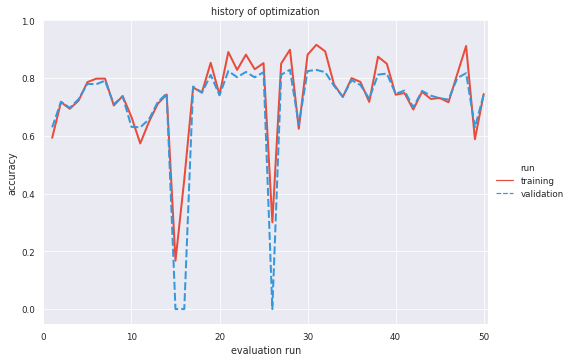

In [146]:
plot_optimization_history(model2_run2_trials)

<a id='ha_train'></a>
#### Train optimized model
[back to table of contents](#toc)

In [16]:
from hyperopt import fmin, tpe, hp, Trials
from hyperopt import STATUS_OK

x_train, y_train, x_test, y_test = data()
w2v = pickle.load(open(data_folder+'w2v.p', 'rb'))

In [19]:
K.clear_session()
m2 = build_hier_model(vectors=w2v, optimizer='rmsprop', 
                             learn_rate=0.0, dropout_rate1=0.3504, 
                             dropout_rate2=0.0074, max_length=50, projected_dim=200, 
                             num_classes=1, num_hidden=200)
#early_stopping = EarlyStopping(monitor='val_loss', patience=4)
m2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2, 50)             0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 2, 400)            321943200 
_________________________________________________________________
bidirectional_2 (Bidirection (None, 2, 400)            721200    
_________________________________________________________________
attention__layer_2 (Attentio (None, 400)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 401       
Total params: 322,745,201
Trainable params: 1,423,601
Non-trainable params: 321,321,600
_________________________________________________________________


In [20]:
learn_rate = LearningRateScheduler(model2_exp_decay(0.00275, 0.1875))
result = m2.fit(x_train, y_train, batch_size= 128, epochs=40,
  validation_split=0.1, callbacks=[learn_rate])

Train on 243784 samples, validate on 27088 samples
Epoch 1/40
243784/243784 [==============================] - 161s 660us/step - loss: 0.5419 - acc: 0.7173 - val_loss: 0.5068 - val_acc: 0.7480
Epoch 2/40
243784/243784 [==============================] - 160s 654us/step - loss: 0.4715 - acc: 0.7676 - val_loss: 0.4535 - val_acc: 0.7813
Epoch 3/40
243784/243784 [==============================] - 159s 654us/step - loss: 0.4252 - acc: 0.7963 - val_loss: 0.4240 - val_acc: 0.7979
Epoch 4/40
243784/243784 [==============================] - 160s 655us/step - loss: 0.3866 - acc: 0.8189 - val_loss: 0.4066 - val_acc: 0.8104
Epoch 5/40
243784/243784 [==============================] - 160s 654us/step - loss: 0.3533 - acc: 0.8375 - val_loss: 0.3950 - val_acc: 0.8184
Epoch 6/40
243784/243784 [==============================] - 160s 655us/step - loss: 0.3222 - acc: 0.8552 - val_loss: 0.4026 - val_acc: 0.8200
Epoch 7/40
243784/243784 [==============================] - 160s 656us/step - loss: 0.2944 - acc:

<a id='ha_pred'></a>
#### Predict test data
[back to table of contents](#toc)

In [23]:
y_pred_dl2 = m2.predict(x_test, batch_size=128)

target_names = ['not duplicate', 'duplicate']

convert_binary = lambda x: 1 if x[0] >= .5 else 0

y_pred_dl2_classes = np.array([convert_binary(y) for y in y_pred_dl2])

<a id='ha_eval'></a>
#### Evaluate Model
[back to table of contents](#toc)

In [28]:
score_dl2 = accuracy_score(y_test.values, y_pred_dl2_classes)
rscore_dl2 = recall_score(y_test.values, y_pred_dl2_classes)
pscore_dl2 = precision_score(y_test.values, y_pred_dl2_classes)
print('Accuracy score for DL method 2 ', score_dl2)
print('Recall score for DL method 2 ', rscore_dl2)
print('Precision score for DL method 2 ', pscore_dl2)

Accuracy score for DL method 2  0.8332496345988082
Recall score for DL method 2  0.794518596891023
Precision score for DL method 2  0.7627204719026506


In [29]:
print(classification_report(y_test.values, y_pred_dl2_classes, target_names=target_names))

               precision    recall  f1-score   support

not duplicate       0.88      0.86      0.87     84267
    duplicate       0.76      0.79      0.78     49148

    micro avg       0.83      0.83      0.83    133415
    macro avg       0.82      0.83      0.82    133415
 weighted avg       0.84      0.83      0.83    133415



In [147]:
m2_fpr, m2_tpr, _ = roc_curve(y_test.values, y_pred_dl2_classes)
m2_roc_auc = auc(m2_fpr, m2_tpr)

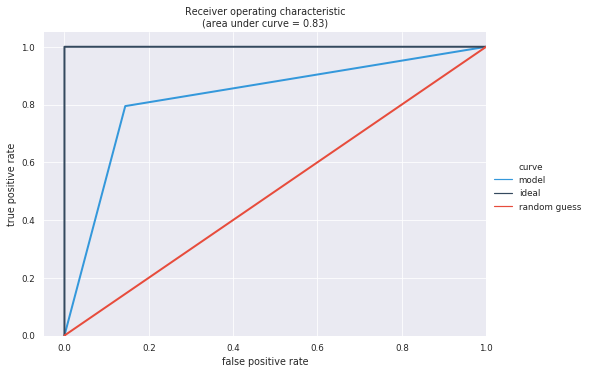

In [156]:
plot_roc(m2_fpr, m2_tpr, m2_roc_auc)